# **Multi-class texture analysis in colorectal cancer histology project**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing the relevante libraries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

##Importing the Dataset:

In [ ]:
import tensorflow_datasets as tfds

X, Y = tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

print('X.shape =',X.shape)
print('np.unique(Y) =',np.unique(Y))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete340T25/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
X.shape = (5000, 150, 150, 3)
np.unique(Y) = [0 1 2 3 4 5 6 7]


#### In this code snippet, we observe that our dataset comprises images with dimensions 5000x150x150x3, representing 8 distinct classes (indexed from 0 to 7) for each melanoma case. Additionally, for demonstrative purposes, we have arranged some of the images by their respective classes:

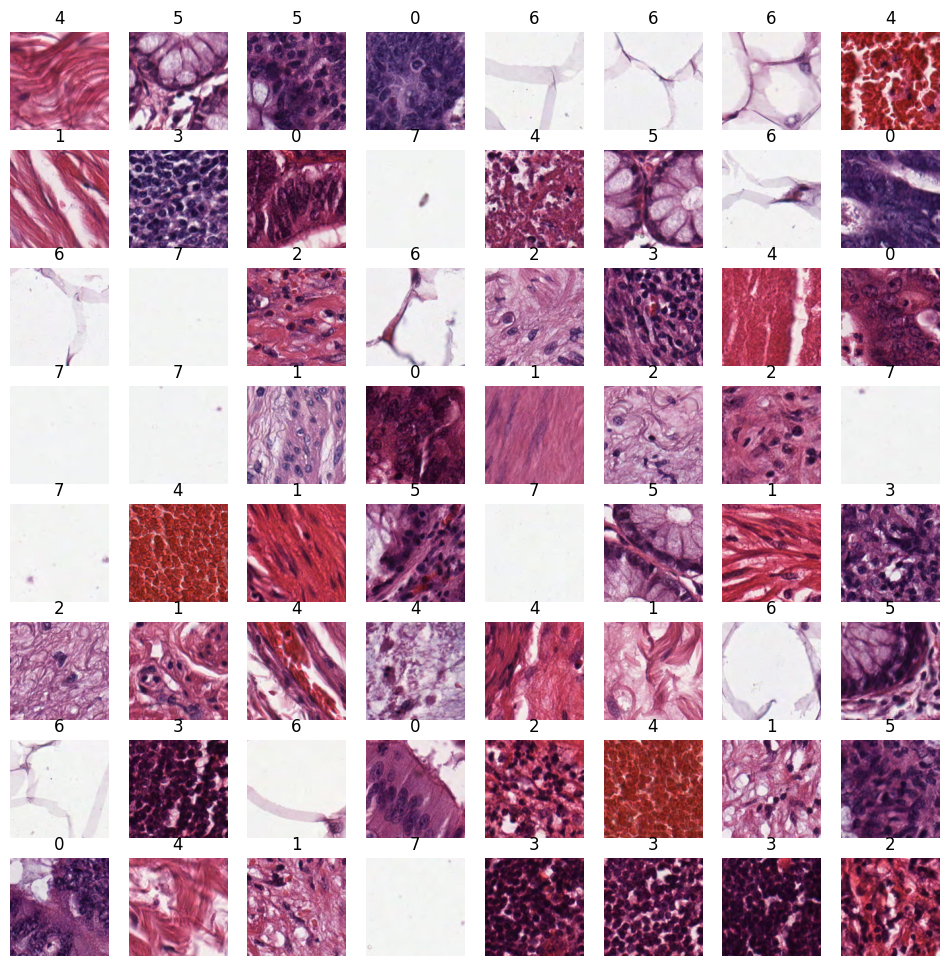

In [ ]:
plt.figure(figsize=(12,12))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
    plt.title(Y[i])

##Splitting the Data into Train and Test Sets:

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. flatten the labels (easier to deal with)
y_train = y_train.flatten()  # (4000, 1) -> (4000,)
y_test = y_test.flatten()    # (1000, 1) -> (1000,)

# 3. convert uint8->float32 and normalize range to 0.0-1.0
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 4. define the 8 classes names
class_names = ['Tumour epithelium','Simple stroma','Complex stroma','Immune cells','Debris','Normal mucosal glands','Adipose tissue','Background (no tissue)']

# 5. print the shapes
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

# 150*150*3 = 67,500-D

x_train.shape = (4000, 150, 150, 3)
y_train.shape = (4000,)
x_test.shape = (1000, 150, 150, 3)
y_test.shape = (1000,)


#### We began by splitting the dataset into training and testing sets, assigning 80% for training and reserving 20% for testing purposes. Following this, we flattened the labels to streamline subsequent operations. We then converted the image data to float32 format and scaled pixel values to range from 0.0 to 1.0. Additionally, we defined a list comprising eight class names, each representing distinct tissue types. To conclude, we printed out the shapes of both the training and testing sets, and made a note of the total feature dimensionality, which amounted to 67,500.

#### In addition, we opted to assign numerical labels to each pairing of dimensionality reduction technique and classifier method, numbering them from 1 to 9. Initially, we started with the dimensionality reduction technique of downsampling, applying the classification methods post-reduction. We followed this sequence for subsequent reduction techniques. For instance, combination 1 denotes downsampling the images from 150x150 to 32x32 coupled with an SVM classifier.

##1. Working with downsampling the Images from 150x150 to 32x32:

In [ ]:
import tensorflow as tf

# Perform dimension reduction to 32x32 pixels for both train and test sets
x_train_downsampled = tf.image.resize(x_train, [32, 32]).numpy()
x_test_downsampled = tf.image.resize(x_test, [32, 32]).numpy()

# 32*32*3 = 3,072-D

# Reshape the downsampled data
x_train_downsampled_flat = x_train_downsampled.reshape(x_train_downsampled.shape[0], -1)
x_test_downsampled_flat = x_test_downsampled.reshape(x_test_downsampled.shape[0], -1)

print('x_train_downsampled_flat.shape =',x_train_downsampled_flat.shape)
print('x_test_downsampled_flat.shape =',x_test_downsampled_flat.shape)

x_train_downsampled_flat.shape = (4000, 3072)
x_test_downsampled_flat.shape = (1000, 3072)


## SVM (Combination 1):

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a list of C values to try
c_values = [0.01, 0.1, 1.0, 10.0]

# Initialize dictionaries to store training and testing accuracies for each C
train_accuracies = {}
test_accuracies = {}

# Initialize variables to track the best C and its corresponding accuracy
best_c = None
best_test_accuracy = 0.0

# Loop over different C values
for c in c_values:
    # Initialize an SVM classifier with the current C value
    svm_classifier = SVC(C=c, kernel='linear')

    # Train the SVM classifier on the entire training set
    svm_classifier.fit(x_train_downsampled_flat, y_train)

    # Predict on the training set
    y_train_pred = svm_classifier.predict(x_train_downsampled_flat)

    # Calculate training accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies[c] = train_accuracy

    # Predict on the test set
    y_pred = svm_classifier.predict(x_test_downsampled_flat)

    # Calculate testing accuracy and store it
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies[c] = test_accuracy

    # Check if this is the best C so far
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_c = c

# Print the results for each C value
for c in c_values:
    print(f'C = {c}:')
    print(f'Training Accuracy: {train_accuracies[c]}')
    print(f'Testing Accuracy: {test_accuracies[c]}')
    print()

# Print the best C and its corresponding accuracy on the test set
print(f'Best C: {best_c}')
print(f'Best Testing Accuracy: {best_test_accuracy}')


C = 0.01:
Training Accuracy: 0.82875
Testing Accuracy: 0.688

C = 0.1:
Training Accuracy: 0.97725
Testing Accuracy: 0.627

C = 1.0:
Training Accuracy: 0.997
Testing Accuracy: 0.611

C = 10.0:
Training Accuracy: 0.999
Testing Accuracy: 0.604

Best C: 0.01
Best Testing Accuracy: 0.688


#### Training and predict:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize an SVM classifier with the best C value
svm_classifier = SVC(C=0.01, kernel='linear')

# Train the SVM classifier with the best C value on the entire training set
svm_classifier.fit(x_train_downsampled_flat, y_train)

# svm_classifier is our trained SVM
y_pred_downsamp_svm = svm_classifier.predict(x_test_downsampled_flat)

#### Accuracy:

In [ ]:
# Calculate training and testing accuracy
train_accuracy_downsamp_svm = svm_classifier.score(x_train_downsampled_flat, y_train)
print(f"Training accuracy: {train_accuracy_downsamp_svm*100:.2f}%")
test_accuracy_downsamp_svm = svm_classifier.score(x_test_downsampled_flat, y_test)
print(f"Testing accuracy: {test_accuracy_downsamp_svm*100:.2f}%")

Training accuracy: 82.88%
Testing accuracy: 68.80%


#### We can see that there is a slight overfitting.

#### Confusion Matrix:

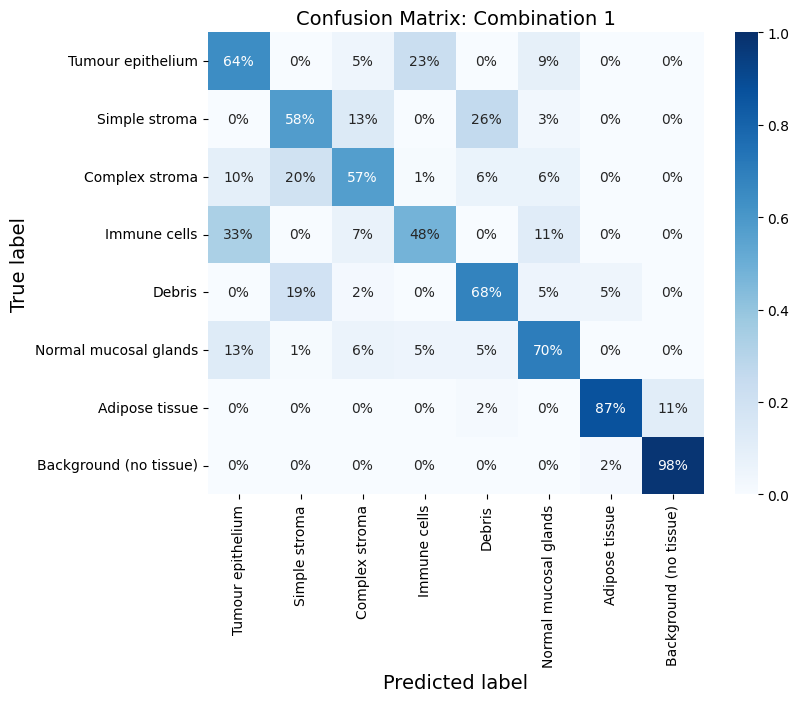

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_downsamp_svm, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 1', fontsize=14)
plt.show()

#### We can see that most classes achieve a prediction success rate of approximately 60% which is not that good.

#### t-SNE:

<ipython-input-94-e6487aedf6e9>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_1[:, 0], x_test_tsne_1[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


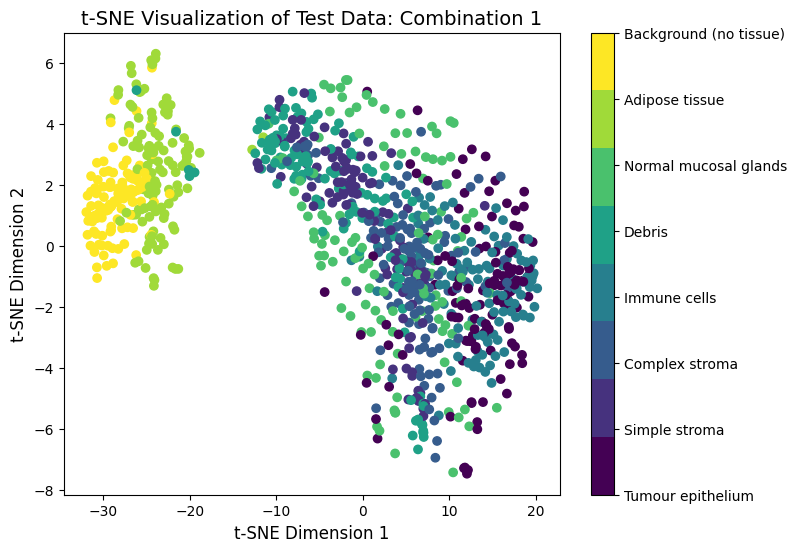

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_downsampled_flat)
tsne = TSNE(n_components=2)
x_test_tsne_1 = tsne.fit_transform(x_test_downsampled_flat)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_1[:, 0], x_test_tsne_1[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 1', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### we can see that the classification performance across most classes appears to be subpar, with the exception of Background and Adipose tissues, which demonstrate a relatively better classification accuracy. This observation aligns with the results depicted in the confusion matrix.

## Softmax Classifier (Combination 2):

### Build and Train Softmax Classifier:

In [ ]:
# Define the model architecture
model_softmax_downsamp = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='softmax', input_shape=(x_train_downsampled_flat.shape[1],))
])

# Compile the model
model_softmax_downsamp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_softmax_downsamp = model_softmax_downsamp.fit(x_train_downsampled_flat, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_test_downsampled_flat, y_test))


Epoch 1/50
63/63 [==============================] - 8s 21ms/step - loss: 1.8124 - accuracy: 0.2600 - val_loss: 1.5563 - val_accuracy: 0.3240
Epoch 2/50
63/63 [==============================] - 0s 8ms/step - loss: 1.4966 - accuracy: 0.3745 - val_loss: 1.4396 - val_accuracy: 0.3730
Epoch 3/50
63/63 [==============================] - 0s 7ms/step - loss: 1.3730 - accuracy: 0.4162 - val_loss: 1.3867 - val_accuracy: 0.4190
Epoch 4/50
63/63 [==============================] - 1s 8ms/step - loss: 1.2945 - accuracy: 0.4582 - val_loss: 1.3292 - val_accuracy: 0.4120
Epoch 5/50
63/63 [==============================] - 0s 8ms/step - loss: 1.2286 - accuracy: 0.4848 - val_loss: 1.3685 - val_accuracy: 0.3710
Epoch 6/50
63/63 [==============================] - 0s 8ms/step - loss: 1.1905 - accuracy: 0.4935 - val_loss: 1.2688 - val_accuracy: 0.4210
Epoch 7/50
63/63 [==============================] - 0s 6ms/step - loss: 1.1512 - accuracy: 0.5275 - val_loss: 1.2438 - val_accuracy: 0.4310
Epoch 8/50
63/63 [=

####Accuracy

In [ ]:
# Calculate training accuracy
train_loss_downsamp_softmax, train_accuracy_downsamp_softmax = model_softmax_downsamp.evaluate(x_train_downsampled_flat, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy_downsamp_softmax*100:.2f}%")

# Calculate testing accuracy
test_loss_downsamp_softmax, test_accuracy_downsamp_softmax = model_softmax_downsamp.evaluate(x_test_downsampled_flat, y_test, verbose=0)
print(f"Testing accuracy: {test_accuracy_downsamp_softmax*100:.2f}%")


Training accuracy: 75.98%
Testing accuracy: 48.30%


#### We can see a siginificant overfitting.

### Visualizing Results (Loss and Accuracy Curves)

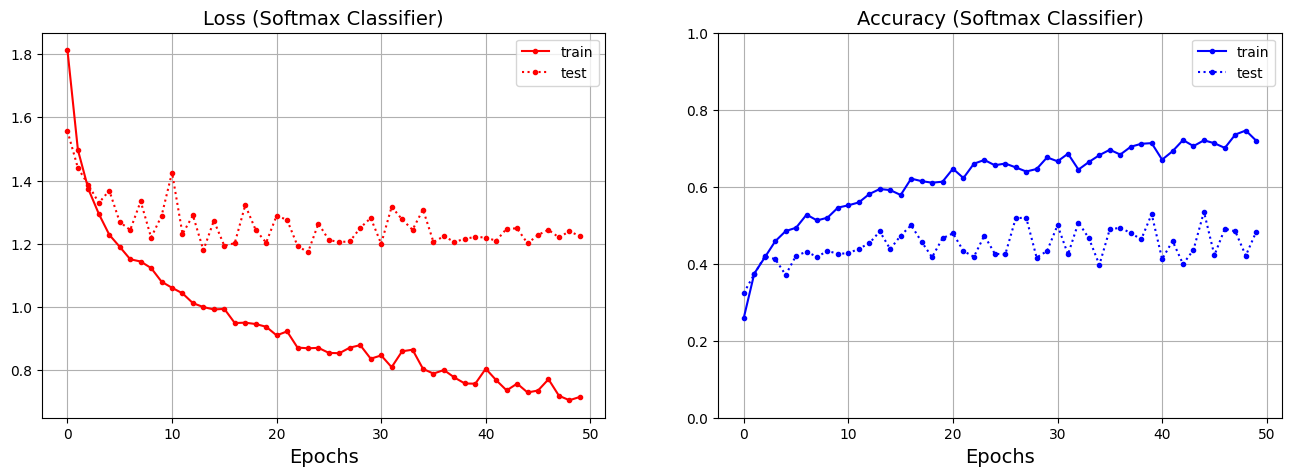

In [ ]:
plt.figure(figsize=(16,5))

# Softmax Classifier
plt.subplot(1,2,1)
plt.plot(history_softmax_downsamp.history['loss'],'.-r', label='train')
plt.plot(history_softmax_downsamp.history['val_loss'],'.:r', label='test')
plt.title('Loss (Softmax Classifier)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_softmax_downsamp.history['accuracy'],'.-b', label='train')
plt.plot(history_softmax_downsamp.history['val_accuracy'],'.:b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy (Softmax Classifier)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.show()

#### The divergence between the training and test results, along with their slight misalignment, indicates a potential overfitting issue in the performance. This is further highlighted by the observed gap between the two curves on the Loss and Accuracy plots.

#### Confusion Matrix:




32/32 [==============================] - 0s 3ms/step


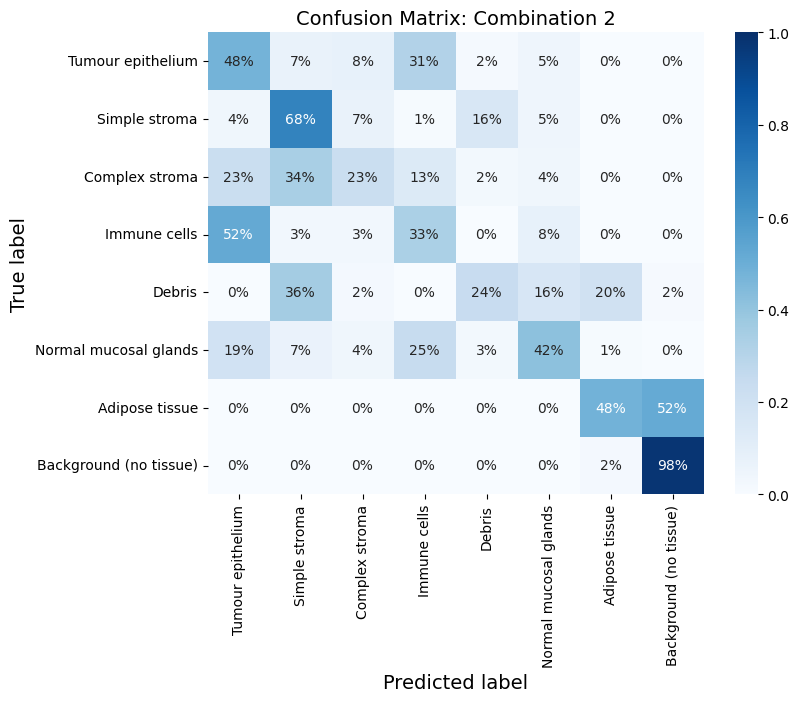

In [ ]:
y_pred_softmax_downsamp = model_softmax_downsamp.predict(x_test_downsampled_flat).argmax(axis=1)

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_softmax_downsamp, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 2', fontsize=14)
plt.show()

#### We can see that most classes achieved a poor prediction success rate.

####t-SNE

<ipython-input-11-6909d1035c40>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_2[:, 0], x_test_tsne_2[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


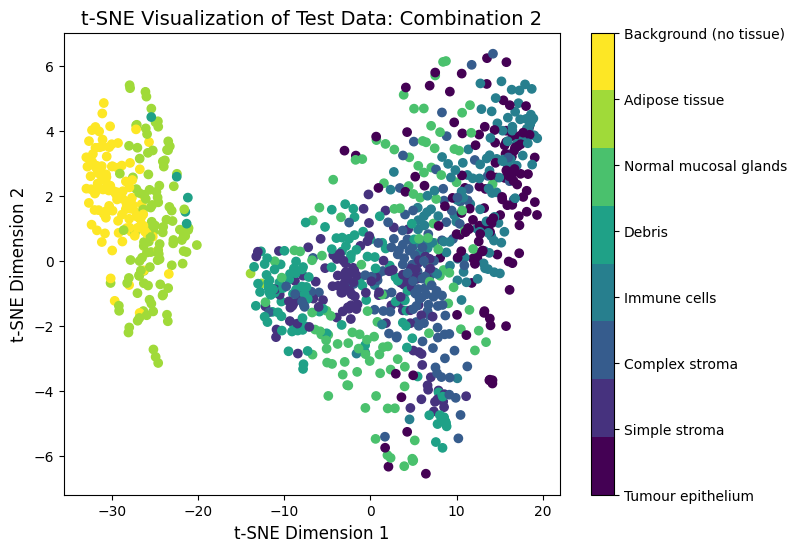

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_downsampled_flat)
tsne = TSNE(n_components=2)
x_test_tsne_2 = tsne.fit_transform(x_test_downsampled_flat)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_2[:, 0], x_test_tsne_2[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 2', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### Across most classes, we observe a subpar classification performance with significant overlap.

##Neural Network (128-D Dense Layer + Softmax Classifier) [Combination 3]:

###Build and Train Neural Network:

In [ ]:
# Define the model architecture
model_nn_downsamp = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train_downsampled_flat.shape[1],)),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
model_nn_downsamp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_nn_downsamp = model_nn_downsamp.fit(x_train_downsampled_flat, y_train, validation_data=(x_test_downsampled_flat, y_test), epochs=50, batch_size=64,verbose=1)

Epoch 1/50
63/63 [==============================] - 1s 7ms/step - loss: 1.8851 - accuracy: 0.2627 - val_loss: 1.6378 - val_accuracy: 0.2690
Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 1.4861 - accuracy: 0.3570 - val_loss: 1.4037 - val_accuracy: 0.3430
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 1.3596 - accuracy: 0.4268 - val_loss: 1.3522 - val_accuracy: 0.3850
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 1.2529 - accuracy: 0.4493 - val_loss: 1.2718 - val_accuracy: 0.4000
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 1.1662 - accuracy: 0.5015 - val_loss: 1.1912 - val_accuracy: 0.4350
Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 1.1496 - accuracy: 0.5165 - val_loss: 1.1767 - val_accuracy: 0.4870
Epoch 7/50
63/63 [==============================] - 0s 4ms/step - loss: 1.1171 - accuracy: 0.5188 - val_loss: 1.2679 - val_accuracy: 0.4320
Epoch 8/50
63/63 [==

####Accuracy

In [ ]:
# Calculate training accuracy
train_loss_downsamp_nn, train_accuracy_downsamp_nn = model_nn_downsamp.evaluate(x_train_downsampled_flat, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy_downsamp_nn*100:.2f}%")

# Calculate testing accuracy
test_loss_downsamp_nn, test_accuracy_downsamp_nn = model_nn_downsamp.evaluate(x_test_downsampled_flat, y_test, verbose=0)
print(f"Testing accuracy: {test_accuracy_downsamp_nn*100:.2f}%")

Training accuracy: 83.38%
Testing accuracy: 56.30%


#### We can see a significant overfitting.

###Visualizing Results (Loss and Accuracy Curves):

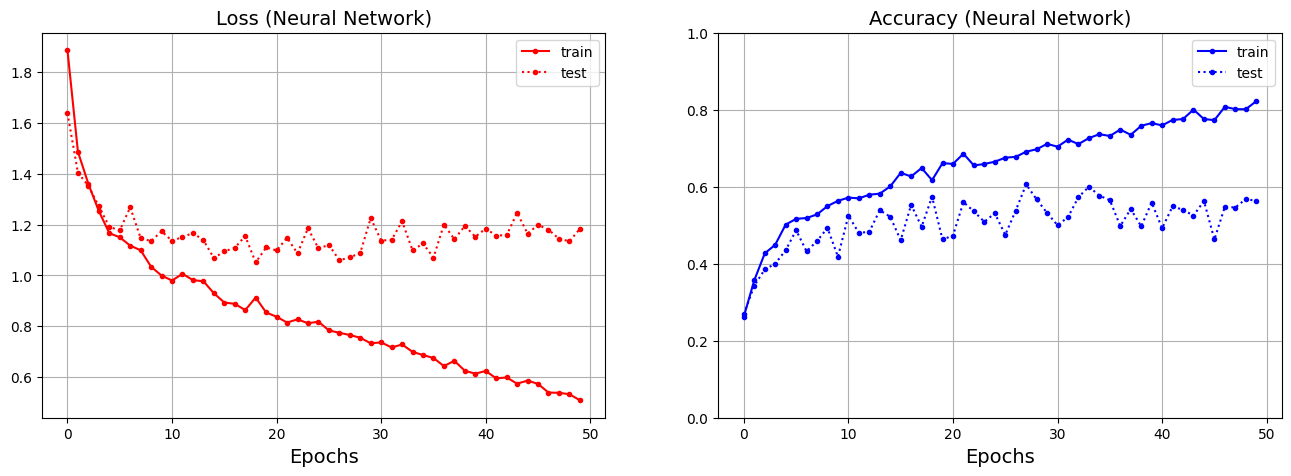

In [ ]:
plt.figure(figsize=(16,5))
# Neural Network
plt.subplot(1,2,1)
plt.plot(history_nn_downsamp.history['loss'],'.-r', label='train')
plt.plot(history_nn_downsamp.history['val_loss'],'.:r', label='test')
plt.title('Loss (Neural Network)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_nn_downsamp.history['accuracy'],'.-b', label='train')
plt.plot(history_nn_downsamp.history['val_accuracy'],'.:b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy (Neural Network)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.show()

#### It's evident from the Loss and Accuracy curves that there exists a noticeable gap between the training and test results. Additionally, they exhibit contrasting directional trends, indicating a potential issue of overfitting in the model performance.

#### Confusion Matrix:

32/32 [==============================] - 0s 2ms/step


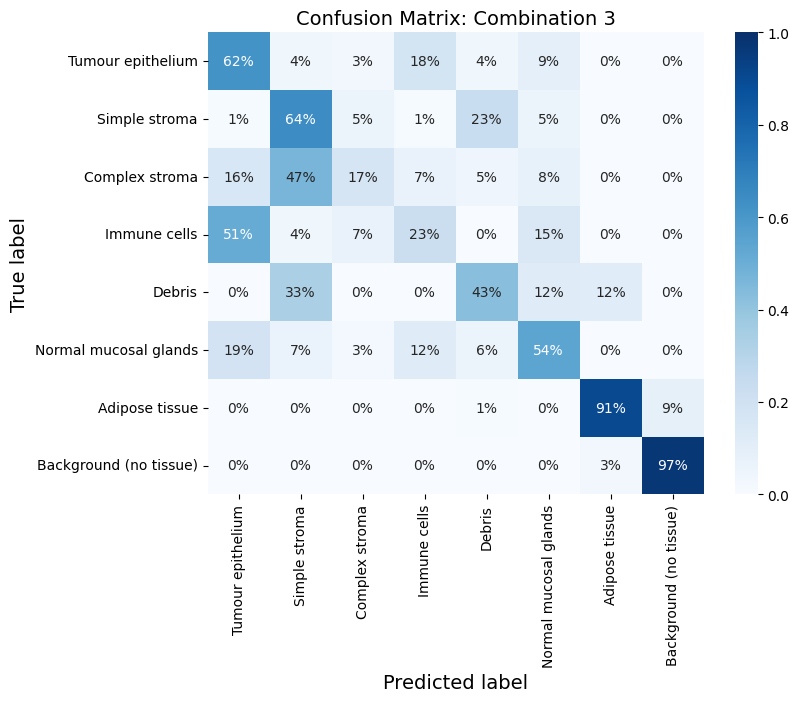

In [ ]:
y_pred_nn_downsamp = model_nn_downsamp.predict(x_test_downsampled_flat).argmax(axis=1)

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_nn_downsamp, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 3', fontsize=14)
plt.show()

####In this confusion matrix results, it's evident that the majority of classes exhibit low prediction success rates. However, Background and Adipose tissues stand out with notably high prediction rates.

####t-SNE

<ipython-input-16-89ee861c5c0a>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_3[:, 0], x_test_tsne_3[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


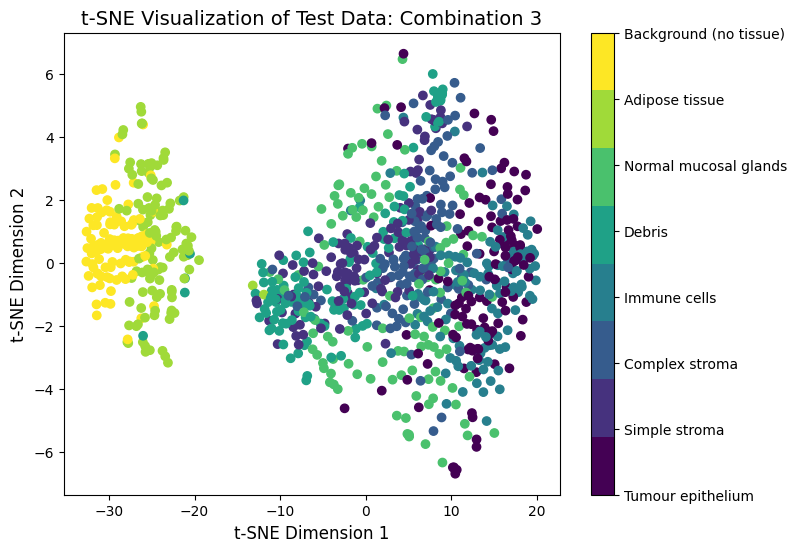

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_downsampled_flat)
tsne = TSNE(n_components=2)
x_test_tsne_3 = tsne.fit_transform(x_test_downsampled_flat)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_3[:, 0], x_test_tsne_3[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 3', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### We observe generally weak classification across most classes with significant overlap. However, it's worth noting that Background and Adipose classes show a relatively better degree of classification.

##2. Working with PCA:

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=256, random_state=0)
x_train_pca = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], -1))

print('x_train_pca.shape =', x_train_pca.shape)
print('x_test_pca.shape =', x_test_pca.shape)

x_train_pca.shape = (4000, 256)
x_test_pca.shape = (1000, 256)


## SVM (Combination 4):

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a list of C values to try
c_values = [0.01, 0.1, 1.0, 10.0]

# Initialize dictionaries to store training and testing accuracies for each C
train_accuracies = {}
test_accuracies = {}

# Initialize variables to track the best C and its corresponding accuracy
best_c = None
best_test_accuracy = 0.0

# Loop over different C values
for c in c_values:
    # Initialize an SVM classifier with the current C value
    svm_classifier = SVC(C=c, kernel='linear')

    # Train the SVM classifier on the entire training set
    svm_classifier.fit(x_train_pca, y_train)

    # Predict on the training set
    y_train_pred = svm_classifier.predict(x_train_pca)

    # Calculate training accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies[c] = train_accuracy

    # Predict on the test set
    y_pred = svm_classifier.predict(x_test_pca)

    # Calculate testing accuracy and store it
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies[c] = test_accuracy

    # Check if this is the best C so far
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_c = c

# Print the results for each C value
for c in c_values:
    print(f'C = {c}:')
    print(f'Training Accuracy: {train_accuracies[c]}')
    print(f'Testing Accuracy: {test_accuracies[c]}')
    print()

# Print the best C and its corresponding accuracy on the test set
print(f'Best C: {best_c}')
print(f'Best Testing Accuracy: {best_test_accuracy}')


C = 0.01:
Training Accuracy: 0.85
Testing Accuracy: 0.635

C = 0.1:
Training Accuracy: 0.891
Testing Accuracy: 0.593

C = 1.0:
Training Accuracy: 0.90375
Testing Accuracy: 0.587

C = 10.0:
Training Accuracy: 0.909
Testing Accuracy: 0.576

Best C: 0.01
Best Testing Accuracy: 0.635


###Training an SVM:

In [ ]:
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_classifier = SVC(C=0.01, kernel='linear')
svm_classifier.fit(x_train_pca, y_train)

# svm_classifier is our trained SVM
y_pred_pca_svm = svm_classifier.predict(x_test_pca)

####Accuracy:

In [ ]:
# Calculate training and testing accuracy
train_accuracy_pca_svm = svm_classifier.score(x_train_pca, y_train)
print(f"Training accuracy: {train_accuracy_pca_svm*100:.2f}%")
test_accuracy_pca_svm = svm_classifier.score(x_test_pca, y_test)
print(f"Testing accuracy: {test_accuracy_pca_svm*100:.2f}%")

Training accuracy: 85.00%
Testing accuracy: 63.50%


#### We can see that there is an overfitting.

####Confusion Matrix:

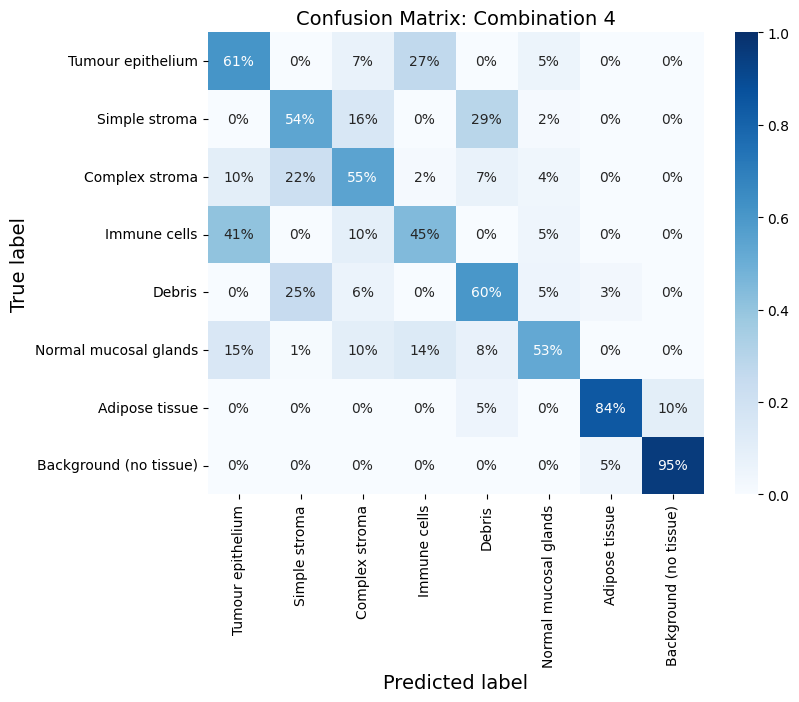

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_pca_svm, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 4', fontsize=14)
plt.show()

#### We observe that the majority of classes attain prediction rates ranging around 50% to 60%. However, Background and Adipose tissues stand out with notably high prediction rates, underscoring the overall suboptimal performance.

####t-SNE:

<ipython-input-21-dec4e8eaf1c6>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_4[:, 0], x_test_tsne_4[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


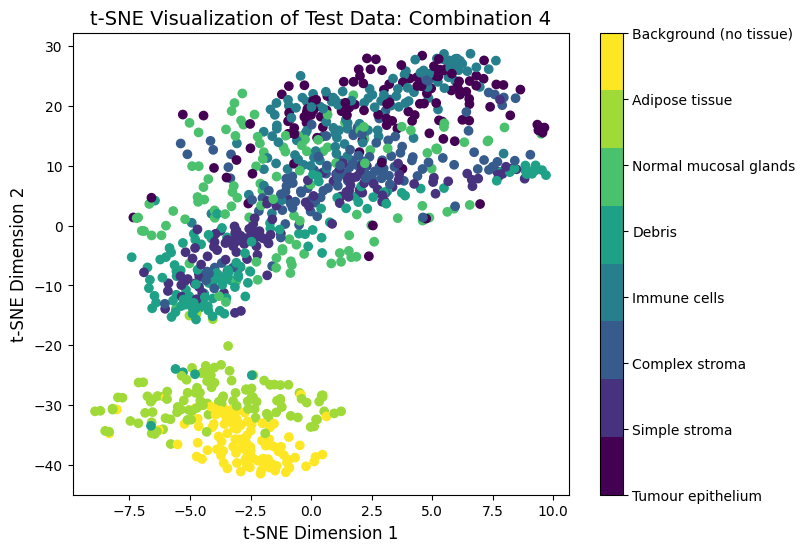

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_pca)
tsne = TSNE(n_components=2)
x_test_tsne_4 = tsne.fit_transform(x_test_pca)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_4[:, 0], x_test_tsne_4[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 4', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### We note a poor level of classification performance across most classes, accompanied by a noticeable degree of overlap. Nevertheless, it's important to highlight that Background and Adipose classes display a comparatively more distinct and discernible clustering arrangement.

## Softmax Classifier (Combination 5):

### Build and Train Softmax Classifier:

In [ ]:
# Define the model architecture
model_softmax_pca = tf.keras.Sequential([
    Dense(8, activation='softmax')
])

# Compile the model
model_softmax_pca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_softmax_pca = model_softmax_pca.fit(x_train_pca, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_test_pca, y_test))

Epoch 1/50
63/63 [==============================] - 1s 6ms/step - loss: 3.9553 - accuracy: 0.2403 - val_loss: 3.0114 - val_accuracy: 0.3090
Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 2.5970 - accuracy: 0.3243 - val_loss: 2.3516 - val_accuracy: 0.3430
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 1.9886 - accuracy: 0.3855 - val_loss: 1.9485 - val_accuracy: 0.3850
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 1.5905 - accuracy: 0.4392 - val_loss: 1.6754 - val_accuracy: 0.4080
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 1.3315 - accuracy: 0.5055 - val_loss: 1.5080 - val_accuracy: 0.4270
Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 1.1653 - accuracy: 0.5458 - val_loss: 1.3929 - val_accuracy: 0.4490
Epoch 7/50
63/63 [==============================] - 0s 4ms/step - loss: 1.0559 - accuracy: 0.5732 - val_loss: 1.3220 - val_accuracy: 0.4410
Epoch 8/50
63/63 [==

####Accuracy:

In [ ]:
# Calculate training accuracy
train_loss_pca_softmax, train_accuracy_pca_softmax = model_softmax_pca.evaluate(x_train_pca, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy_pca_softmax*100:.2f}%")

# Calculate testing accuracy
test_loss_pca_softmax, test_accuracy_pca_softmax = model_softmax_pca.evaluate(x_test_pca, y_test, verbose=0)
print(f"Testing accuracy: {test_accuracy_pca_softmax*100:.2f}%")

Training accuracy: 76.17%
Testing accuracy: 55.80%


#### We can see an overfitting in this case.

### Visualizing Results (Loss and Accuracy Curves)

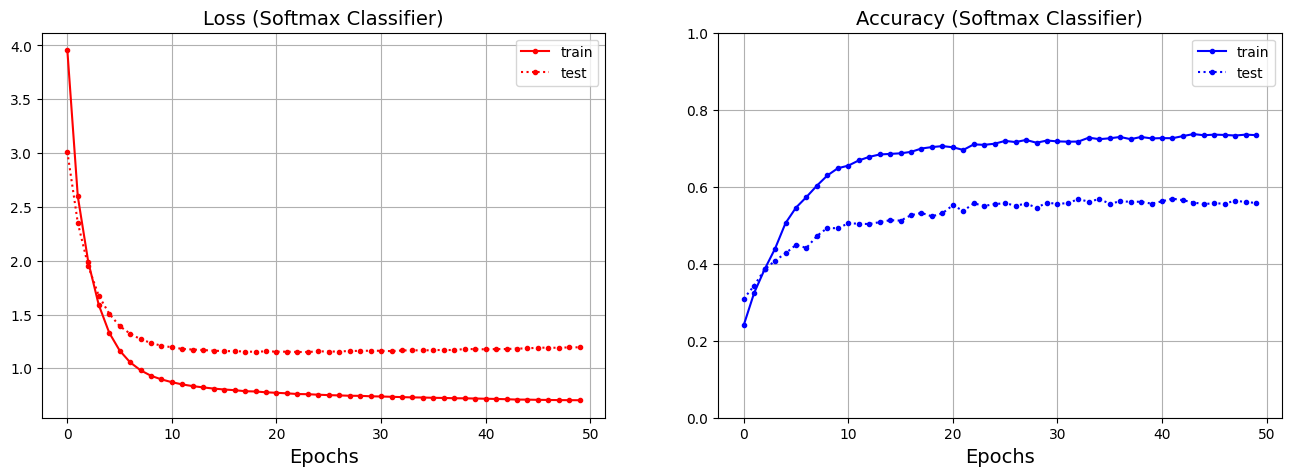

In [ ]:
plt.figure(figsize=(16,5))

# Softmax Classifier
plt.subplot(1,2,1)
plt.plot(history_softmax_pca.history['loss'],'.-r', label='train')
plt.plot(history_softmax_pca.history['val_loss'],'.:r', label='test')
plt.title('Loss (Softmax Classifier)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_softmax_pca.history['accuracy'],'.-b', label='train')
plt.plot(history_softmax_pca.history['val_accuracy'],'.:b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy (Softmax Classifier)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.show()

#### The small gap between the training and testing results suggests overfitting. While the model performs adequately on the training data (76.17% accuracy), it struggles with new, unseen data (55.80% accuracy), indicating a need for regularization or other corrective measures.

####Confusion Matrix:

32/32 [==============================] - 0s 3ms/step


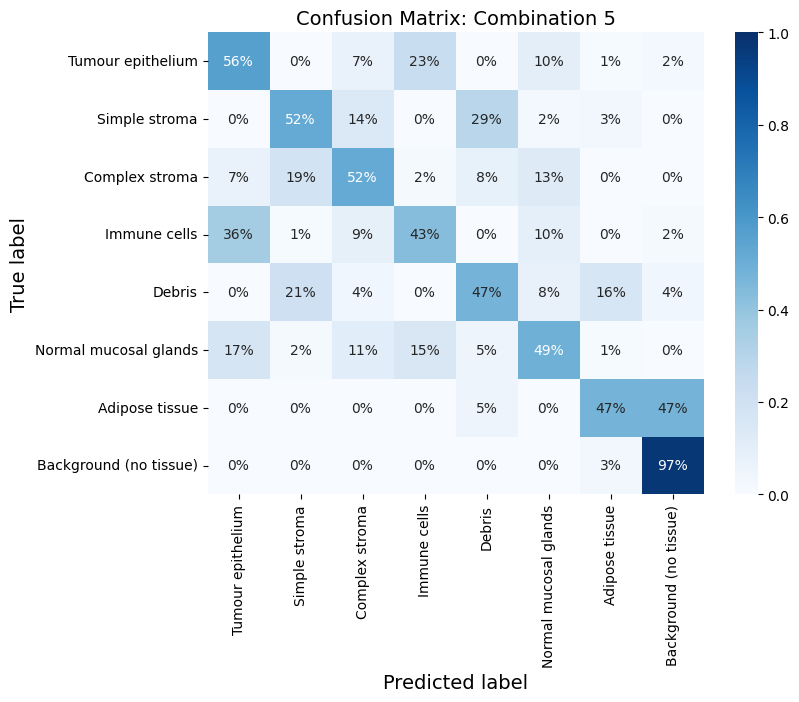

In [ ]:
y_pred_softmax_pca = model_softmax_pca.predict(x_test_pca).argmax(axis=1)

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_softmax_pca, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 5', fontsize=14)
plt.show()

#### We can see that most classes have achieved prediction rates around 50%. However, the Background class shows notably high prediction rates, indicating overall suboptimal performance.

####t-SNE:

<ipython-input-26-ece52b0cabdb>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_5[:, 0], x_test_tsne_5[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


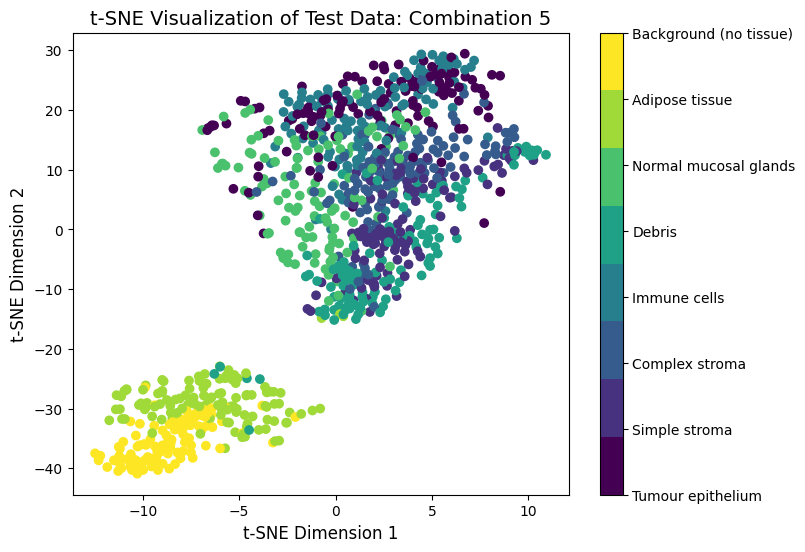

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_pca)
tsne = TSNE(n_components=2)
x_test_tsne_5 = tsne.fit_transform(x_test_pca)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_5[:, 0], x_test_tsne_5[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 5', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()


#### We note a limited classification performance in most classes, characterized by substantial overlap. However, there is an observable, though not entirely precise, clustering pattern present in the Background class.

##Neural Network (128-D Dense Layer + Softmax Classifier) [Combination 6]:

###Build and Train Neural Network:

In [ ]:
# Define the model architecture
model_nn_pca = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
model_nn_pca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_nn_pca = model_nn_pca.fit(x_train_pca, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_test_pca, y_test))

Epoch 1/50
63/63 [==============================] - 1s 6ms/step - loss: 2.5348 - accuracy: 0.3385 - val_loss: 1.4892 - val_accuracy: 0.4610
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 0.9985 - accuracy: 0.6145 - val_loss: 1.2468 - val_accuracy: 0.5410
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.7094 - accuracy: 0.7280 - val_loss: 1.1411 - val_accuracy: 0.5870
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 0.5566 - accuracy: 0.8033 - val_loss: 1.0938 - val_accuracy: 0.5880
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 0.4530 - accuracy: 0.8555 - val_loss: 1.0797 - val_accuracy: 0.5950
Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 0.3793 - accuracy: 0.8860 - val_loss: 1.0782 - val_accuracy: 0.6050
Epoch 7/50
63/63 [==============================] - 0s 4ms/step - loss: 0.3196 - accuracy: 0.9155 - val_loss: 1.0849 - val_accuracy: 0.6180
Epoch 8/50
63/63 [==

####Accuarcy:

In [ ]:
# Calculate training accuracy
train_loss_pca_nn, train_accuracy_pca_nn = model_nn_pca.evaluate(x_train_pca, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy_pca_nn*100:.2f}%")

# Calculate testing accuracy
test_loss_pca_nn, test_accuracy_pca_nn = model_nn_pca.evaluate(x_test_pca, y_test, verbose=0)
print(f"Testing accuracy: {test_accuracy_pca_nn*100:.2f}%")

Training accuracy: 99.83%
Testing accuracy: 61.90%


#### We can see a significant overfitting in here.

### Visualizing Results (Loss and Accuracy Curves)

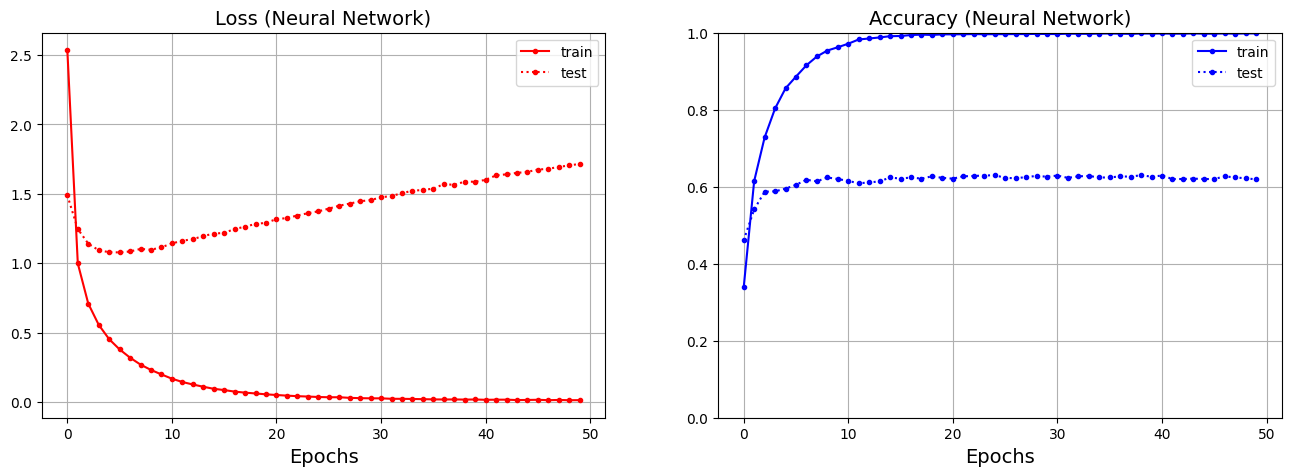

In [ ]:
plt.figure(figsize=(16,5))
# Neural Network
plt.subplot(1,2,1)
plt.plot(history_nn_pca.history['loss'],'.-r', label='train')
plt.plot(history_nn_pca.history['val_loss'],'.:r', label='test')
plt.title('Loss (Neural Network)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_nn_pca.history['accuracy'],'.-b', label='train')
plt.plot(history_nn_pca.history['val_accuracy'],'.:b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy (Neural Network)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.show()

#### It's evident from the Loss and Accuracy curves that there is a substantial gap between the training and test results. Furthermore, they exhibit divergent trends, particularly noticeable from around epoch 4 onwards (we can see a breaking point on the loss graph), indicating a significant overfitting issue in the performance.

####Confusion Matrix:

32/32 [==============================] - 0s 2ms/step


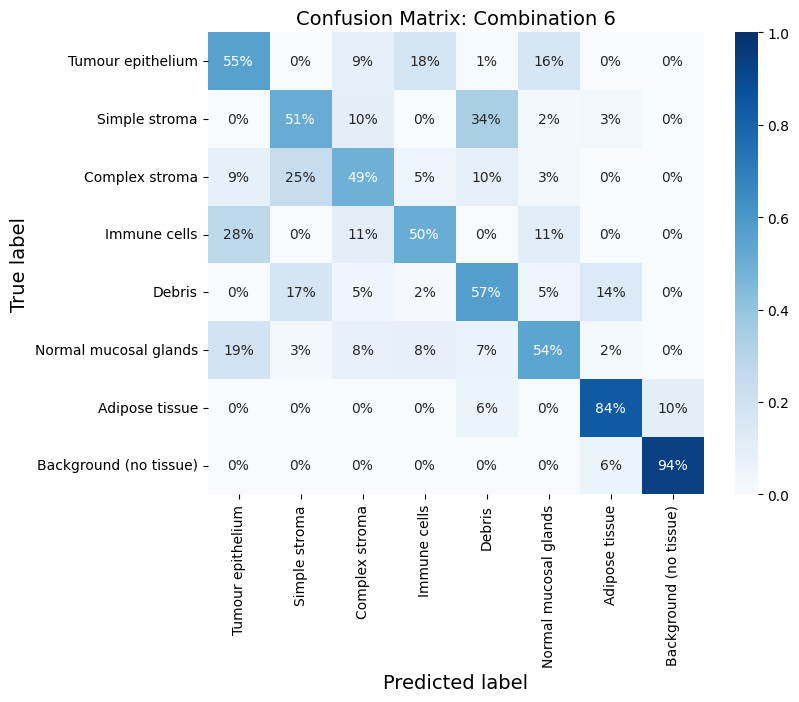

In [ ]:
y_pred_nn_pca = model_nn_pca.predict(x_test_pca).argmax(axis=1)

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_nn_pca, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 6', fontsize=14)
plt.show()

#### We observe that the majority of classes have achieved prediction rates ranging from 50% to 57% which are indicating a poor preformance. However, Background and Adipose tissues stand out with notably high prediction rates, suggesting room for improvement in overall performance.

####t-SNE:

32/32 [==============================] - 0s 2ms/step


<ipython-input-31-7e4319e916c6>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_6[:, 0], x_test_tsne_6[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


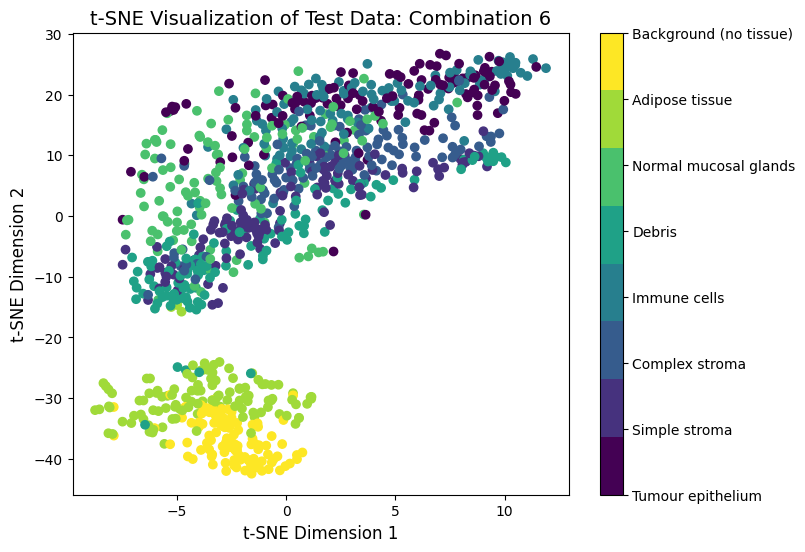

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_train_pca)
tsne = TSNE(n_components=2)
# Get the output probabilities from the neural network model
y_test_probs_nn = intermediate_layer_model.predict(x_test_pca)

x_test_tsne_6 = tsne.fit_transform(x_test_pca)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_6[:, 0], x_test_tsne_6[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 6', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### We observe poor classification in most classes, characterized by considerable overlap and noise. However, when it comes to the Background and Adipose classes, there is a discernible but not entirely accurate clustering pattern, albeit not particularly robust.

##3. Working with VGG16:

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

model = Sequential()

model.add(VGG16(include_top=False, input_shape=(150,150,3)))
model.add(Flatten())

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 14714688 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Extract features from the VGG16 model
x_train_features = model.predict(x_train)
x_test_features = model.predict(x_test)

32/32 [==============================] - 3s 108ms/step


##SVM (Combination 7):

In [ ]:
# Define a list of C values to try
c_values = [0.01, 0.1, 1.0, 10.0]

# Initialize dictionaries to store training and testing accuracies for each C
train_accuracies = {}
test_accuracies = {}

# Initialize variables to track the best C and its corresponding accuracy
best_c = None
best_test_accuracy = 0.0

# Loop over different C values
for c in c_values:
    # Initialize an SVM classifier with the current C value
    svm_classifier = SVC(C=c, kernel='linear')

    # Train the SVM classifier on the entire training set
    svm_classifier.fit(x_train_features, y_train)

    # Predict on the training set
    y_train_pred = svm_classifier.predict(x_train_features)

    # Calculate training accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies[c] = train_accuracy

    # Predict on the test set
    y_pred = svm_classifier.predict(x_test_features)

    # Calculate testing accuracy and store it
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies[c] = test_accuracy

    # Check if this is the best C so far
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_c = c

# Print the results for each C value
for c in c_values:
    print(f'C = {c}:')
    print(f'Training Accuracy: {train_accuracies[c]}')
    print(f'Testing Accuracy: {test_accuracies[c]}')
    print()

# Print the best C and its corresponding accuracy on the test set
print(f'Best C: {best_c}')
print(f'Best Testing Accuracy: {best_test_accuracy}')

C = 0.01:
Training Accuracy: 0.9835
Testing Accuracy: 0.874

C = 0.1:
Training Accuracy: 0.9985
Testing Accuracy: 0.869

C = 1.0:
Training Accuracy: 0.99925
Testing Accuracy: 0.869

C = 10.0:
Training Accuracy: 1.0
Testing Accuracy: 0.865

Best C: 0.01
Best Testing Accuracy: 0.874


###Training an SVM:

In [ ]:
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_classifier = SVC(C=0.01, kernel='linear')
svm_classifier.fit(x_train_features, y_train)

# svm_classifier is our trained SVM
y_pred_vgg_svm = svm_classifier.predict(x_test_features)

####Accuracy:

In [ ]:
# Calculate training and testing accuracy
train_accuracy_vgg_svm = svm_classifier.score(x_train_features, y_train)
print(f"Training accuracy: {train_accuracy_vgg_svm*100:.2f}%")
test_accuracy_vgg_svm = svm_classifier.score(x_test_features, y_test)
print(f"Testing accuracy: {test_accuracy_vgg_svm*100:.2f}%")

Training accuracy: 98.35%
Testing accuracy: 87.40%


#### We can see a very slight overfitting.

####Confusion Matrix:

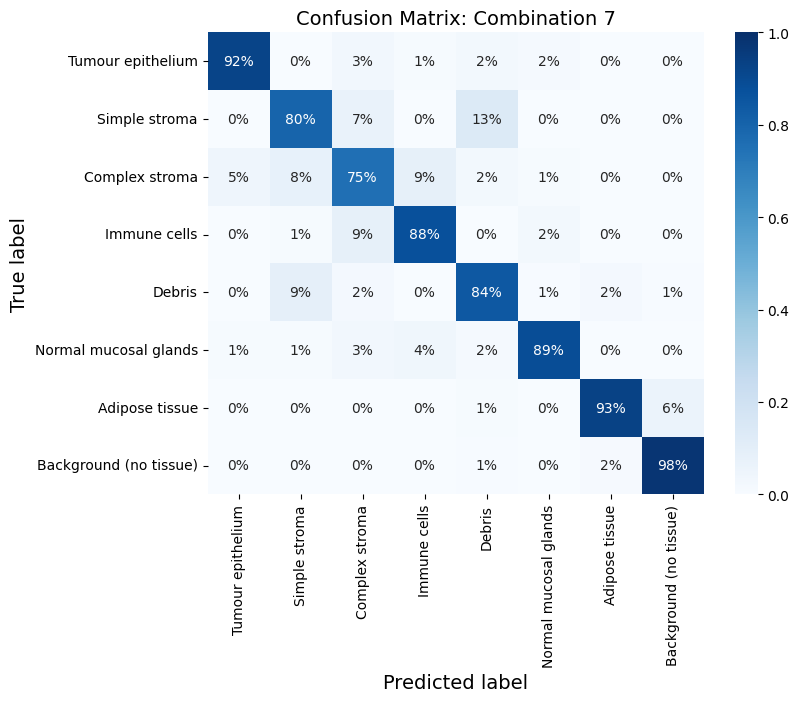

In [ ]:
# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_vgg_svm, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 7', fontsize=14)
plt.show()

#### We can see that the confusion matrix reveals high prediction rates across nearly all classes, with only one class achieving a 75% accuracy. Overall, these results are quite favorable

####t-SNE:

<ipython-input-73-4a4de9e87edd>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne_7[:, 0], x_test_tsne_7[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


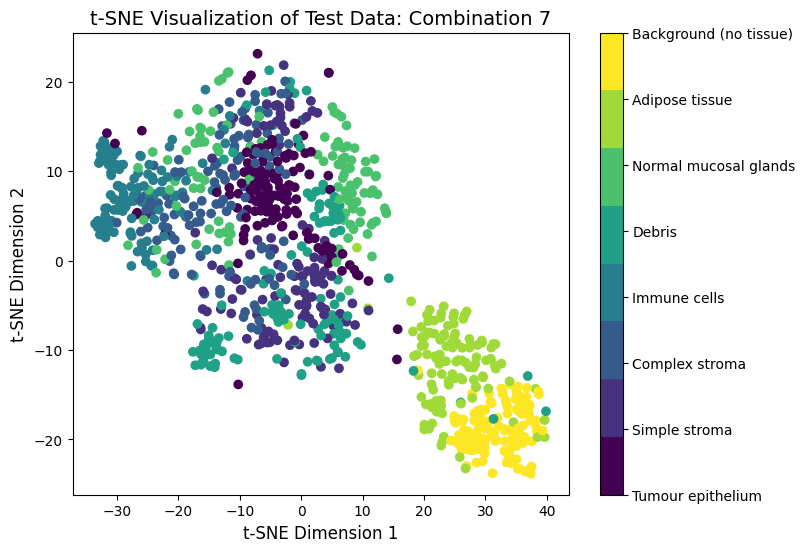

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_features)
tsne = TSNE(n_components=2)
x_test_tsne_7 = tsne.fit_transform(x_test_features)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne_7[:, 0], x_test_tsne_7[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 7', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### Despite promising train/test results, we can see that the classification in most classes is not flawless, with some overlap and noise observed. The classes are beginning to take on a recognizable shape. However, for Background, Adipose, and Normal Mucosal Glands classes, the classification is somewhat discernible but not entirely satisfactory to the human eye.

##Softmax Classifier (Combination 8):

####Build and Train Softmax Classifier:

In [ ]:
# Define the model architecture
model_softmax_vgg = tf.keras.Sequential([
    Dense(8, input_shape=(None,8192), activation='softmax')
])

# Compile the model
model_softmax_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_softmax_vgg = model_softmax_vgg.fit(x_train_features, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_test_features, y_test))

Epoch 1/50
63/63 [==============================] - 1s 12ms/step - loss: 0.7473 - accuracy: 0.7520 - val_loss: 0.5095 - val_accuracy: 0.8150
Epoch 2/50
63/63 [==============================] - 1s 12ms/step - loss: 0.4005 - accuracy: 0.8712 - val_loss: 0.4473 - val_accuracy: 0.8410
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.3140 - accuracy: 0.8953 - val_loss: 0.4133 - val_accuracy: 0.8510
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 0.2641 - accuracy: 0.9178 - val_loss: 0.4060 - val_accuracy: 0.8510
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 0.2231 - accuracy: 0.9350 - val_loss: 0.3964 - val_accuracy: 0.8600
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1955 - accuracy: 0.9477 - val_loss: 0.3692 - val_accuracy: 0.8720
Epoch 7/50
63/63 [==============================] - 0s 4ms/step - loss: 0.1636 - accuracy: 0.9567 - val_loss: 0.3690 - val_accuracy: 0.8790
Epoch 8/50
63/63 [

####Accuracy:

In [ ]:
# Calculate training accuracy
train_loss_vgg_softmax, train_accuracy_vgg_softmax = model_softmax_vgg.evaluate(x_train_features, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy_vgg_softmax*100:.2f}%")

# Calculate testing accuracy
test_loss_vgg_softmax, test_accuracy_vgg_softmax = model_softmax_vgg.evaluate(x_test_features, y_test, verbose=0)
print(f"Testing accuracy: {test_accuracy_vgg_softmax*100:.2f}%")

Training accuracy: 99.85%
Testing accuracy: 86.50%


#### We can see a very slight overfitting.

### Visualizing Results (Loss and Accuracy Curves)

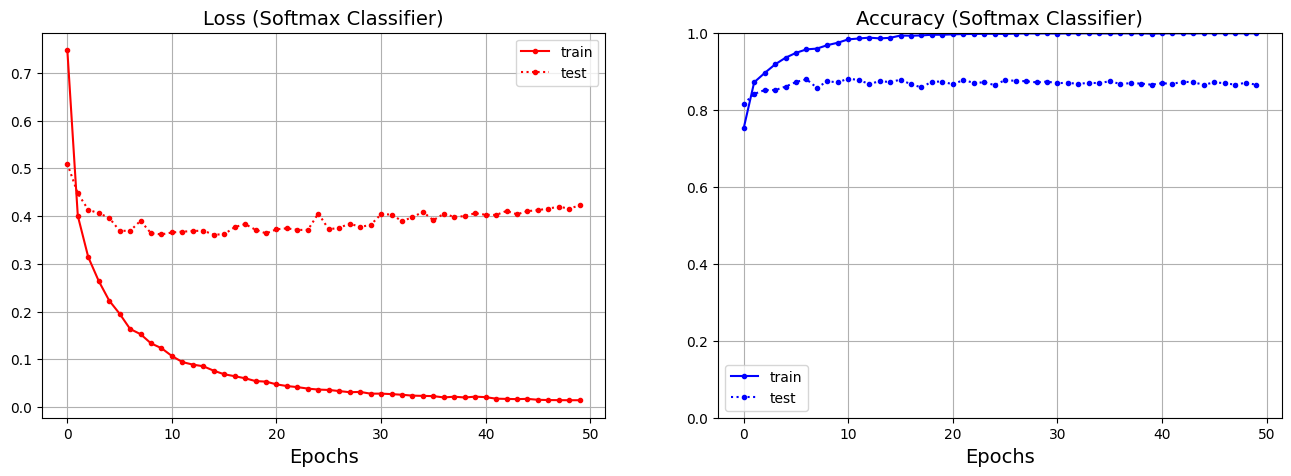

In [ ]:
plt.figure(figsize=(16,5))

# Softmax Classifier
plt.subplot(1,2,1)
plt.plot(history_softmax_vgg.history['loss'],'.-r', label='train')
plt.plot(history_softmax_vgg.history['val_loss'],'.:r', label='test')
plt.title('Loss (Softmax Classifier)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_softmax_vgg.history['accuracy'],'.-b', label='train')
plt.plot(history_softmax_vgg.history['val_accuracy'],'.:b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy (Softmax Classifier)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.show()

#### Examining the loss and accuracy curves, we observe a substantial plateau-like gap in the loss graph, indicating potential overfitting. Despite this, the accuracy curves reveal a relatively smaller discrepancy, signifying robust performance on unseen data. With an impressive training accuracy of 99.85% and a testing accuracy of 86.50%, there's a notable difference between the two. However, the model's capacity to maintain high testing accuracy in the presence of a plateau-shaped loss gap suggests its ability to generalize well to new data, highlighting its overall strong performance.

####Confusion Matrix:

32/32 [==============================] - 0s 3ms/step


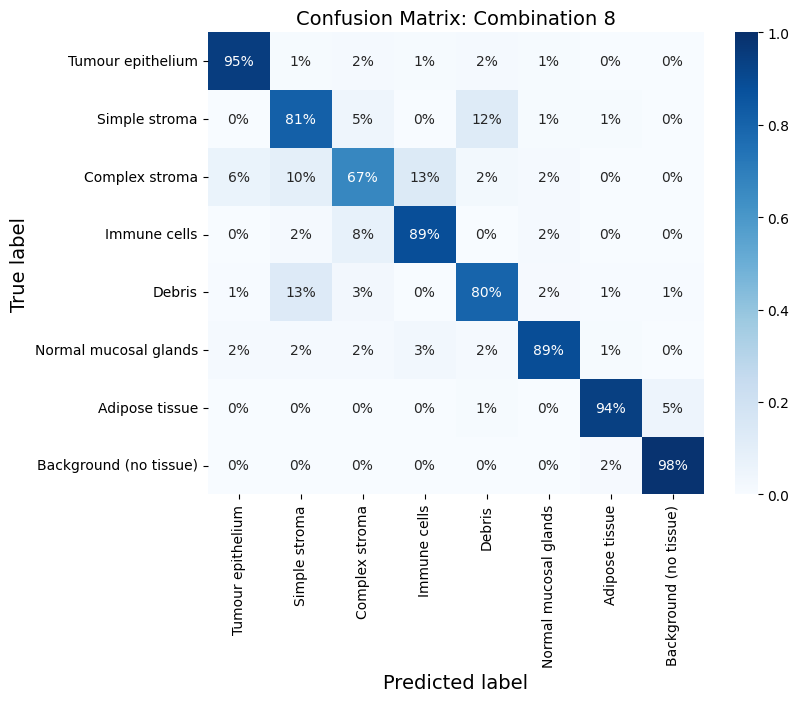

In [ ]:
y_pred_softmax_vgg = model_softmax_vgg.predict(x_test_features).argmax(axis=1)

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_softmax_vgg, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 8', fontsize=14)
plt.show()

#### We can see a high prediction rates in nearly all classes, with the exception of 'Complex Stroma' which achieved 67%. Overall, these results are exceptionally strong.

####t-SNE:

<ipython-input-79-71df17c5b370>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


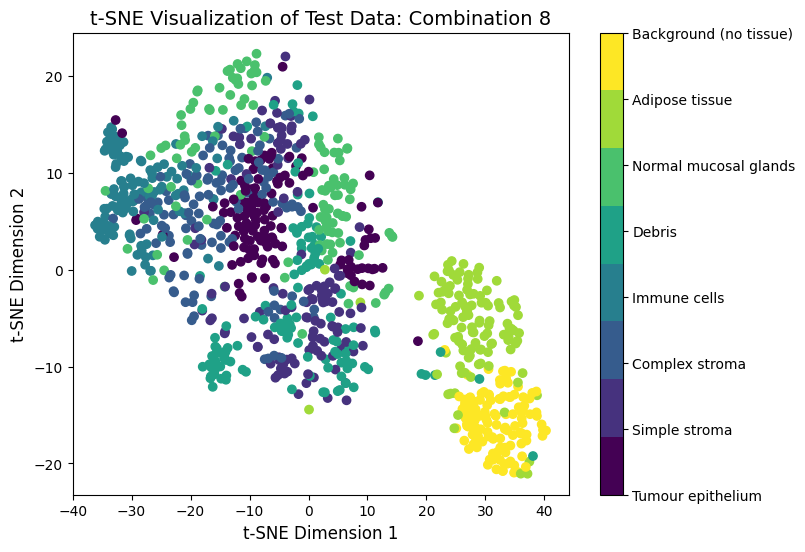

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_features)
tsne = TSNE(n_components=2)
x_test_tsne = tsne.fit_transform(x_test_features)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 8', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### Although the train/test results look good, we still see some imperfections in classifying most groups. There's a bit of mixing and noise in the data, but they're starting to group together better than before. However, for Background, Adipose, and Debris groups, the classification is pretty nice but isn't very clear and might be hard to see for a person.

##Neural Network (128-D Dense Layer + Softmax Classifier) [Combination 9]:

In [ ]:
# Define the model architecture
model_nn_vgg = tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_shape=(None,8192), activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
model_nn_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_nn_vgg = model_nn_vgg.fit(x_train_features, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_test_features, y_test))


Epoch 1/50
63/63 [==============================] - 1s 8ms/step - loss: 0.7424 - accuracy: 0.7483 - val_loss: 0.4645 - val_accuracy: 0.8240
Epoch 2/50
63/63 [==============================] - 0s 6ms/step - loss: 0.3315 - accuracy: 0.8920 - val_loss: 0.4694 - val_accuracy: 0.8320
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 0.2584 - accuracy: 0.9143 - val_loss: 0.4129 - val_accuracy: 0.8380
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1839 - accuracy: 0.9435 - val_loss: 0.3856 - val_accuracy: 0.8710
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9617 - val_loss: 0.4803 - val_accuracy: 0.8390
Epoch 6/50
63/63 [==============================] - 0s 7ms/step - loss: 0.1221 - accuracy: 0.9670 - val_loss: 0.4156 - val_accuracy: 0.8620
Epoch 7/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0989 - accuracy: 0.9762 - val_loss: 0.3878 - val_accuracy: 0.8650
Epoch 8/50
63/63 [==

####Accuarcy:

In [ ]:
# Calculate training accuracy
train_loss_vgg_nn, train_accuracy_vgg_nn = model_nn_vgg.evaluate(x_train_features, y_train, verbose=0)
print(f"Training accuracy: {train_accuracy_vgg_nn*100:.2f}%")

# Calculate testing accuracy
test_loss_vgg_nn, test_accuracy_vgg_nn = model_nn_vgg.evaluate(x_test_features, y_test, verbose=0)
print(f"Testing accuracy: {test_accuracy_vgg_nn*100:.2f}%")


Training accuracy: 99.90%
Testing accuracy: 87.10%


#### We can see a very slight overfitting.

### Visualizing Results (Loss and Accuracy Curves)

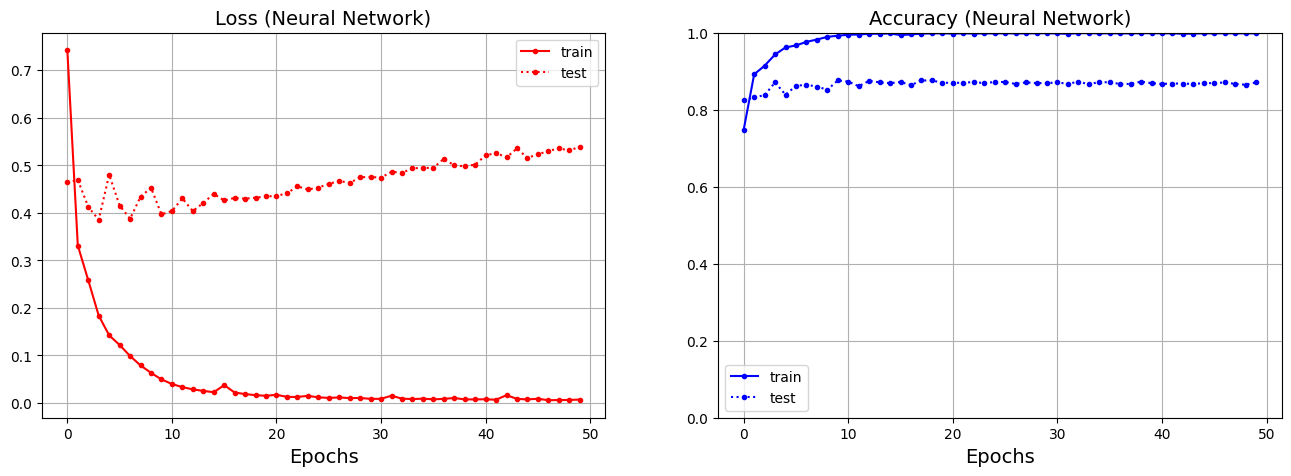

In [ ]:
plt.figure(figsize=(16,5))
# Neural Network
plt.subplot(1,2,1)
plt.plot(history_nn_vgg.history['loss'],'.-r', label='train')
plt.plot(history_nn_vgg.history['val_loss'],'.:r', label='test')
plt.title('Loss (Neural Network)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_nn_vgg.history['accuracy'],'.-b', label='train')
plt.plot(history_nn_vgg.history['val_accuracy'],'.:b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy (Neural Network)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.show()

#### Looking at the loss and accuracy curves, we notice a considerable gap between the training and test loss, suggesting that the model may be overfitting. However, it's important to note that the accuracy curves show a much smaller gap, indicating that the model still performs well on unseen data. The high training accuracy of 99.90% is indeed impressive, but the slightly lower testing accuracy of 87.10% might seem concerning at first. Nonetheless, the model's ability to achieve such a high testing accuracy despite the large loss gap suggests that it's effectively generalizing its learnings to new data. This implies that the model is performing well and has the potential to make accurate predictions on real-world data.

####Confusion Matrix:

32/32 [==============================] - 0s 2ms/step


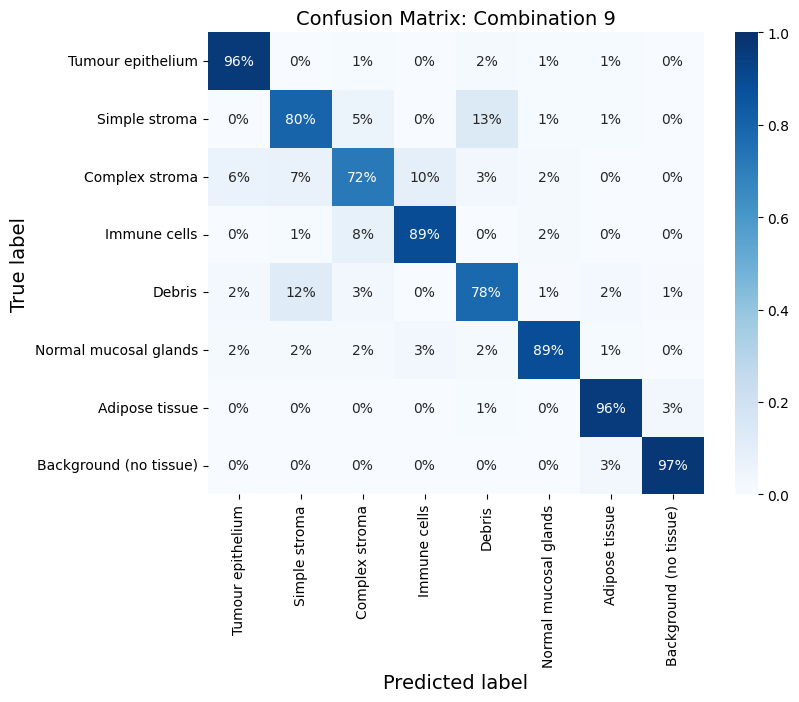

In [ ]:
y_pred_nn_vgg = model_nn_vgg.predict(x_test_features).argmax(axis=1)

# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_nn_vgg, normalize='true')
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(CM, cmap='Blues', annot=True, fmt='.0%', vmin=0, vmax=1,
        xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix: Combination 9', fontsize=14)
plt.show()

#### We can see that the confusion matrix illustrates high prediction rates for nearly all classes, with the exception of 'Complex Stroma' which achieved 72%. Overall, these results are highly commendable.

####t-SNE:

<ipython-input-89-62afbfbbdf5a>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))


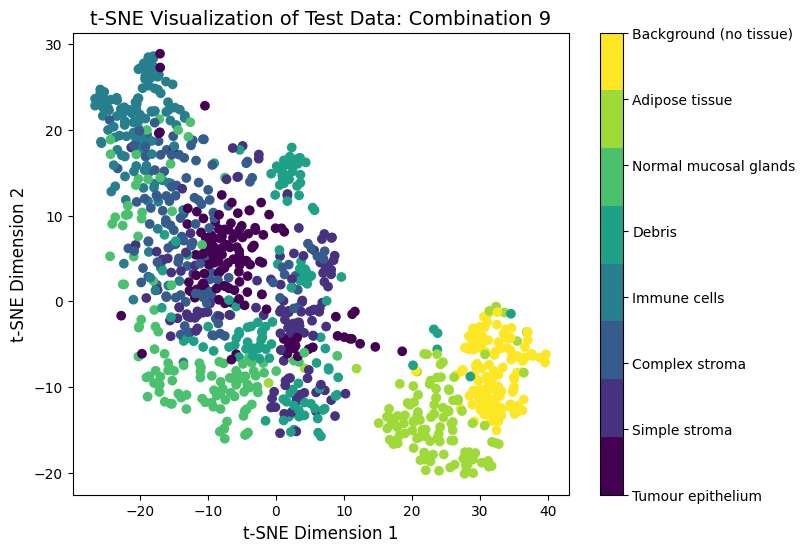

In [ ]:
# 1. Perform t-SNE on the last-step-before-the-final-classifier features (x_test_features)
tsne = TSNE(n_components=2)
x_test_tsne = tsne.fit_transform(x_test_features)

# 2. Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], c=y_test, cmap=plt.cm.get_cmap('viridis', len(class_names)))
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Test Data: Combination 9', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

#### While the training and testing results showed promise, there remains room for improvement in classifying most groups. There is some blending and noise in the data, but they are gradually forming more discernible clusters compared to the previous iteration. However, for Background, Adipose, Immune Cells, Normal mucosal glands and Tumour Epithelium classes, the classification is discernible but not entirely precise or visually clear.

## All 9 Experiments (Combinations) Comparison:

### A Comparison table:

In [ ]:
import pandas as pd

# Create a list of column names
columns = ["Model combination number", "Dimensionality Reduction Technique", "Classifier Technique", "Training accuracy", "Test accuracy"]

# Create a list of dictionaries, where each dictionary represents a row in the dataframe
data = [
    {"Model combination number": 1, "Dimensionality Reduction Technique": "Downsample images to 32 x 32 pixels", "Classifier Technique": "SVM", "Training accuracy": f"{train_accuracy_downsamp_svm*100:.2f}%", "Test accuracy": f"{test_accuracy_downsamp_svm*100:.2f}%"},
    {"Model combination number": 2, "Dimensionality Reduction Technique": "Downsample images to 32 x 32 pixels", "Classifier Technique": "Softmax", "Training accuracy": f"{train_accuracy_downsamp_softmax*100:.2f}%", "Test accuracy": f"{test_accuracy_downsamp_softmax*100:.2f}%"},
    {"Model combination number": 3, "Dimensionality Reduction Technique": "Downsample images to 32 x 32 pixels", "Classifier Technique": "Neural network", "Training accuracy": f"{train_accuracy_downsamp_nn*100:.2f}%", "Test accuracy": f"{test_accuracy_downsamp_nn*100:.2f}%"},
    {"Model combination number": 4, "Dimensionality Reduction Technique": "PCA to 256-D", "Classifier Technique": "SVM", "Training accuracy": f"{train_accuracy_pca_svm*100:.2f}%", "Test accuracy": f"{test_accuracy_pca_svm*100:.2f}%"},
    {"Model combination number": 5, "Dimensionality Reduction Technique": "PCA to 256-D", "Classifier Technique": "Softmax", "Training accuracy": f"{train_accuracy_pca_softmax*100:.2f}%", "Test accuracy": f"{test_accuracy_pca_softmax*100:.2f}%"},
    {"Model combination number": 6, "Dimensionality Reduction Technique": "PCA to 256-D", "Classifier Technique": "Neural network", "Training accuracy": f"{train_accuracy_pca_nn*100:.2f}%", "Test accuracy": f"{test_accuracy_pca_nn*100:.2f}%"},
    {"Model combination number": 7, "Dimensionality Reduction Technique": "VGG-16 backbone", "Classifier Technique": "SVM", "Training accuracy": f"{train_accuracy_vgg_svm*100:.2f}%", "Test accuracy": f"{test_accuracy_vgg_svm*100:.2f}%"},
    {"Model combination number": 8, "Dimensionality Reduction Technique": "VGG-16 backbone", "Classifier Technique": "Softmax", "Training accuracy": f"{train_accuracy_vgg_softmax*100:.2f}%", "Test accuracy": f"{test_accuracy_vgg_softmax*100:.2f}%"},
    {"Model combination number": 9, "Dimensionality Reduction Technique": "VGG-16 backbone", "Classifier Technique": "Neural network", "Training accuracy": f"{train_accuracy_vgg_nn*100:.2f}%", "Test accuracy": f"{test_accuracy_vgg_nn*100:.2f}%"},
]

# Create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data, columns=columns)

# Define a function to highlight the desired row with light blue color
def highlight_row(row):
    conditions = (row["Dimensionality Reduction Technique"] == "VGG-16 backbone") and (row["Classifier Technique"] == "Neural network")
    return ['background-color: lightblue' if conditions else '' for i in row]

# Apply the styling to the entire row
highlighted_df = df.style.apply(highlight_row, axis=1)

# Display the styled DataFrame
highlighted_df


### A bar plot Comparison:

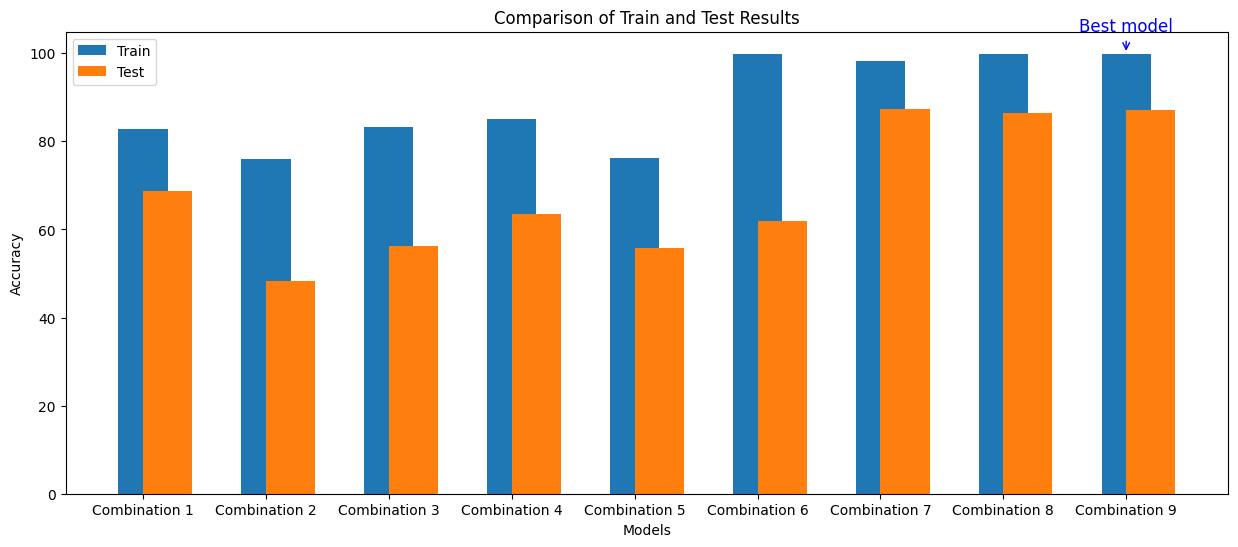

In [ ]:
import matplotlib.pyplot as plt

train_results = [train_accuracy_downsamp_svm*100, train_accuracy_downsamp_softmax*100, train_accuracy_downsamp_nn*100, train_accuracy_pca_svm*100, train_accuracy_pca_softmax*100,train_accuracy_pca_nn*100,train_accuracy_vgg_svm*100,train_accuracy_vgg_softmax*100,train_accuracy_vgg_nn*100    ]
test_results = [test_accuracy_downsamp_svm*100, test_accuracy_downsamp_softmax*100, test_accuracy_downsamp_nn*100, test_accuracy_pca_svm*100, test_accuracy_pca_softmax*100, test_accuracy_pca_nn*100,test_accuracy_vgg_svm*100, test_accuracy_vgg_softmax*100, test_accuracy_vgg_nn*100  ]
labels = ['Combination 1', 'Combination 2', 'Combination 3', 'Combination 4', 'Combination 5', 'Combination 6', 'Combination 7', 'Combination 8', 'Combination 9']

# Set up positions for the bars
x = range(len(labels))

# Create the bar plot
plt.figure(figsize=(15, 6))
plt.bar(x, train_results, width=0.4, label='Train', align='center')
plt.bar(x, test_results, width=0.4, label='Test', align='edge')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Train and Test Results')
plt.xticks(x, labels)
plt.legend()

# Annotate Combination 9
plt.annotate('Best model', xy=(8, max(max(train_results), max(test_results))), xytext=(8, max(max(train_results), max(test_results)) + 5),
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue', fontsize=12, ha='center')

# Show the plot
plt.show()


# **The end!**